# Tekton을 활용한 AI-Devops Pipeline 데모 시나리오

Version Details of the ai-devops used in scenario
- katib v0.14.0
- kserve v0.10.0
- knative-serving v1.2.5
- training-operator v1.5.0
- notebook-controller b0.2.8
- profile-controller v1.6.1
- cluster-local-gateway v1.14.1

Scenario Overview
- notebook에서 다음과 같은 ai-devops 파이프라인을 생성한다.

Scenario Process
- Katib를 활용한 Hyperparameter Tuning 
- 위 튜닝과정을 통해 도출한 best hyperparmeters TFJob에 적용
- TFJob을 통한 분산 트레이닝
- 학습 완료된 모델을 Kserve를 통해 서빙
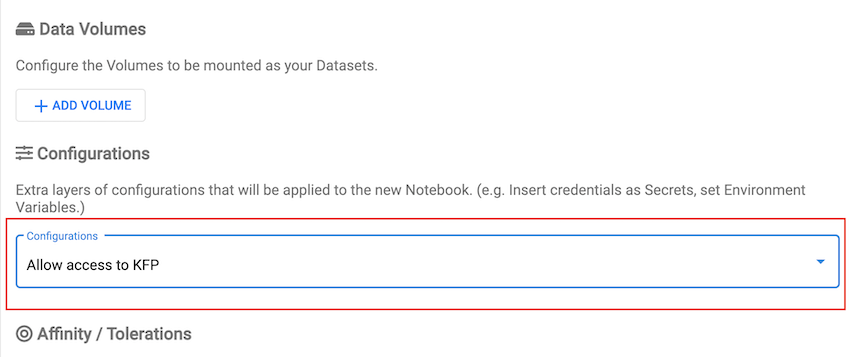

In [ ]:
# 필요한 파이썬 패키지들을 설치한다.
!pip install kfp-tekton==1.2.0
!pip install kubeflow-katib==0.12.0rc0

In [13]:
import kfp
import kfp.dsl as dsl
from kfp import components

from kubeflow.katib import ApiClient
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

## 파이프라인 task들을 정의한다.

파이프라인을 실행시키기 위해 다음 task들을 정의한다.
1. Katib hyperparameter tuning
2. TFJob training
3. KServe inference

### Step 1. Katib hyperparameter tuning task

Katib를 활용한 하이퍼파라미터 튜닝용 pipeline 태스크를 생성한다.
**참고**시나리오에서는 탐색 알고리즘으로 Random Search를 활용하였고, Trial의 worker로 TFJob을 생성하였다.

In [14]:
# Katib의 experiment CR을 생성하는 파이썬 함수는 다음과 같다. 
# 생성할 Experiment의 name, namespace와 진행할 training step의 수를 지정하여야 한다.
def create_katib_experiment_task(experiment_name, experiment_namespace, training_steps):
    # Trial count 지정
    # max_failed는 trial의 최대 실패한도 수로 아래 예시에서는 trial이 세번 실패하면 experiment가 멈추고 status가 failed로 변한다.
    max_trial_count = 5
    max_failed_trial_count = 3
    parallel_trial_count = 2

    # Objective 설정, 하이퍼파라미터 튜닝을 통해 최적화하려는 측정 항목
    objective = V1beta1ObjectiveSpec(
        type="minimize",
        goal=0.001,
        objective_metric_name="loss"
    )

    # Algorithm 설정, katib는 grid, random, bayesian, hyperband등 여러 알고리즘 지원
    algorithm = V1beta1AlgorithmSpec(
        algorithm_name="random",
    )

    # Experiment search space 설정, 탐색할 모든 하이퍼파라미터의 이름과 범위를 지정한다.
    # 아래 예시에서는 learning rate와 batch size라는 하이퍼파라미터를 튜닝한다.   
    parameters = [
        V1beta1ParameterSpec(
            name="learning_rate",
            parameter_type="double",
            feasible_space=V1beta1FeasibleSpace(
                min="0.01",
                max="0.05"
            ),
        ),
        V1beta1ParameterSpec(
            name="batch_size",
            parameter_type="int",
            feasible_space=V1beta1FeasibleSpace(
                min="80",
                max="100"
            ),
        )
    ]

    # Experiment를 통해 실행할 Trial의 template을 정의한다.
    # Trial을 통해 생성된 TFJob 리소스가 complete되게 하기 위하여 istio sidecar inject를 해제하는 annotation은 필수로 달아주어야 한다.    
    trial_spec = {
        "apiVersion": "kubeflow.org/v1",
        "kind": "TFJob",
        "spec": {
            "tfReplicaSpecs": {
                "Chief": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                },
                "Worker": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                }
            }
        }
    }

    # Trial template을 위한 parameter를 구성한다.
    trial_template = V1beta1TrialTemplate(
        primary_container_name="tensorflow",
        primary_pod_labels={"training.kubeflow.org/job-role": "master"},
        trial_parameters=[
            V1beta1TrialParameterSpec(
                name="learningRate",
                description="Learning rate for the training model",
                reference="learning_rate"
            ),
            V1beta1TrialParameterSpec(
                name="batchSize",
                description="Batch size for the model",
                reference="batch_size"
            ),
        ],
        trial_spec=trial_spec
    )

    # 위에서 정의한 파라미터들을 가지고 Experiment 리소스를 생성한다.
    experiment_spec = V1beta1ExperimentSpec(
        max_trial_count=max_trial_count,
        max_failed_trial_count=max_failed_trial_count,
        parallel_trial_count=parallel_trial_count,
        objective=objective,
        algorithm=algorithm,
        parameters=parameters,
        trial_template=trial_template
    )

    # Katib Experiment를 생성하는 task를 만든다.     
    katib_experiment_launcher_op = components.load_component_from_file("./katib-component.yaml")
    op = katib_experiment_launcher_op(
        experiment_name=experiment_name,
        experiment_namespace=experiment_namespace,
        experiment_spec=ApiClient().sanitize_for_serialization(experiment_spec),
        experiment_timeout_minutes=60,
        delete_finished_experiment=False)

    return op

### Step 2. TFJob training task

TFJob을 통한 training을 진행하기 위하여 task를 생성한다.
아래 예시의 TFJob은 각각 1개의 replica를 가지는 Chief와 Worker로 구성되어있다.
**참고**Chief 프로세스는 트레이닝의 조율/분배 및 모델 체크포인트 생성과 같은 역할을 담당하며, Worker 프로세스는 모델을 실제로 트레이닝한다.

In [15]:
# 아래의 파이썬 함수는 이전 step의 하이퍼파라미터 탐색 결과를 변수화 한다.
def convert_katib_results(katib_results) -> str:
    import json
    import pprint
    katib_results_json = json.loads(katib_results)
    print("Katib results:")
    pprint.pprint(katib_results_json)
    best_hps = []
    for pa in katib_results_json["currentOptimalTrial"]["parameterAssignments"]:
        if pa["name"] == "learning_rate":
            best_hps.append("--tf-learning-rate=" + pa["value"])
        elif pa["name"] == "batch_size":
            best_hps.append("--tf-batch-size=" + pa["value"])
    print("Best Hyperparameters: {}".format(best_hps))
    return " ".join(best_hps)

In [16]:
# TFJob task를 생성하는 함수는 다음과 같다.
# 생성할 TFJob의 name, namespace, training step의 수, 그리고 Katib 및 model volume 태스크의 output을 변수로 가진다.
def create_tfjob_task(tfjob_name, tfjob_namespace, training_steps, katib_op, model_volume_op):
    import json
    # Katib experiment로 부터 parameter를 가져온다.
    # 파라미터들은 다음 포맷으로 지정된다 "--tf-learning-rate=0.01 --tf-batch-size=100"
    convert_katib_results_op = components.func_to_container_op(convert_katib_results)
    best_hp_op = convert_katib_results_op(katib_op.output)
    best_hps = str(best_hp_op.output)

    # 위 단계에서 얻은 best 하이퍼파라미터를 가지고 TFJob Chief와 Worker를 정의한다.   
    tfjob_chief_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c"
                        ],
                        "args": [
                            "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps)
                        ],
                        "volumeMounts": [
                            {
                                "mountPath": "/mnt/export",
                                "name": "model-volume"
                            }
                        ]
                    }
                ],
                "volumes": [
                    {
                        "name": "model-volume",
                        "persistentVolumeClaim": {
                            "claimName": str(model_volume_op.outputs["name"])
                        }
                    }
                ]
            }
        }
    }

    tfjob_worker_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c",
                        ],
                        "args": [
                          "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps) 
                        ],
                    }
                ],
            }
        }
    }

    # TFJob 생성을 위한 task를 만든다.
    tfjob_launcher_op = components.load_component_from_file("./tfjob-component.yaml")
    op = tfjob_launcher_op(
        name=tfjob_name,
        namespace=tfjob_namespace,
        chief_spec=json.dumps(tfjob_chief_spec),
        worker_spec=json.dumps(tfjob_worker_spec),
        tfjob_timeout_minutes=60,
        delete_finished_tfjob=False)
    return op

### Step 3. KServe inference

KServe를 활용한 모델 inference task를 생성한다.

In [17]:
# Kserve inferenceservice를 생성하는 함수는 다음과 같다.
# 생성할 kserve isvc의 name과 namespace 그리고 이전 TFJob task와 model volume task의 output을 변수로 설정한다.
def create_kserve_task(model_name, model_namespace, tfjob_op, model_volume_op):

    inference_service = '''
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
  annotations:
    "sidecar.istio.io/inject": "false"
spec:
  predictor:
    model:
      modelFormat:
        name: tensorflow
      storageUri: "pvc://{}/"
'''.format(model_name, model_namespace, str(model_volume_op.outputs["name"]))

    kserve_launcher_op = components.load_component_from_file(
        './kserve-component.yaml')
    kserve_launcher_op(action="create", inferenceservice_yaml=inference_service).after(tfjob_op)

## Create a tekton pipelinerun manifest as yaml

지금까지 정의한 task들과 tekton compiler를 활용해 pipelinerun yaml파일을 생성한다. 
아래 코드를 run하여 생성되는 yaml 파일을 통해 pipelinerun을 배포한다.

pipeline을 실행하여 관련 리소스를 생성하기 위하여 default 서비스어카운트에 kubeflow-admin role을 부여한다.

kfp-tekton-demo 디렉토리의 rolebinding-sample.yaml을 활용하여 생성하거나 아래 명령어를 통해 생성한다.
```
kubectl create rolebinding sample-rolebinding --clusterrole=kubeflow-admin --serviceaccount=demo:default --namespace=demo
```

**참고1**: 생성된 pipelinerun yaml파일은 namespace가 지정되어있지 않기 때문에 파이프라인 정의시에 명시한 namespace (ex)demo에 pipelinerun을 배포하여야한다.  

**참고2**: docker limit으로 인하여 pipeline이 정상적으로 실행되지 않을 수 있으며, 해당 이미지를 프라이빗 레지스트리에 push후 사용하여 해결한다.

**참고3**: 코드 실행중 커널을 리셋하면 변수 지정값도 삭제되므로 앞 단계부터 다시 진행하여 필요한 변수값들을 설정한다.

**참고4**: 파이프라인 재생성시 기존 파이프라인에서 생성한 name이 같은 리소스가 존재하면, pipline이 failed될수 있으므로 생성되었던 pvc, experiment 등의 리소스를 모두 삭제후 재생성한다.

In [18]:
name="mnist-e2e"
namespace="demo"
training_steps="200"

@dsl.pipeline(
    name="end-to-end-pipeline",
    description="An end to end mnist example including hyperparameter tuning, train and inference"
)
def mnist_pipeline(name=name, namespace=namespace, training_steps=training_steps):
    # Katib를 사용하여 하이퍼파라미터 튜닝을 실행한다.
    katib_op = create_katib_experiment_task(name, namespace, training_steps)

    # 모델 학습과 서빙을 위한 volume을 생성한다.
    model_volume_op = dsl.VolumeOp(
        name="model-volume",
        resource_name="model-volume",
        size="1Gi",
        modes=dsl.VOLUME_MODE_RWM
    )

    # TFJob을 활용하여 분산 학습을 진행한다.
    tfjob_op = create_tfjob_task(name, namespace, training_steps, katib_op, model_volume_op)

    # Kserve isvc를 생성하여 모델을 서빙한다.
    create_kserve_task(name, namespace, tfjob_op, model_volume_op)
    
    
from kfp_tekton.compiler import TektonCompiler
    
if __name__ == '__main__':
    TektonCompiler().compile(mnist_pipeline, "mnist_pipeline.yaml")    


## Predict from the trained model

Pipeline 생성이 완료되면 API 엔드포인트를 호출하여 학습된 모델로부터 인퍼런스 응답을 받을수 있다.
디렉토리의 '9.bmp' 파일을 notebook 서버에 업로드 한 후 아래 코드를 실행한다.

In [ ]:
import numpy as np
from PIL import Image
import requests

# 위 단계에서 생성한 pipelinerun이 succeeded된 후 진행한다.
kfp_run = kfp_client.get_run(run_id=run_id)
if kfp_run.run.status == "Succeeded":
    print("Run {} has been Succeeded\n".format(run_id))

    # 이미지 경로 지정
    image = Image.open("9.bmp")
    data = np.array(image.convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)
    data_formatted = np.array2string(data, separator=",", formatter={"float": lambda x: "%.1f" % x})
    json_request = '{{ "instances" : {} }}'.format(data_formatted)

    # Prediction URL을 설정한다. 만약 노트북을 클러스터 외부에서 실행했다면 Cluster IP를 설정하여야한다.
    # Prediction 요청이 로컬 시스템에서 수행되는 경우 아래의 예시에 따라 authservice_session을 추가하여 Kserve 요청을 인증합니다
    # https://github.com/kserve/kserve/tree/master/docs/samples/istio-dex#authentication
    url = "http://{}-predictor-default.{}.svc.cluster.local/v1/models/{}:predict".format(name, namespace, name)
    response = requests.post(url, data=json_request)

    print("Prediction for the image")
    display(image)
    print(response.json())
